In [1]:
import cv2 as cv
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import helpers as hp

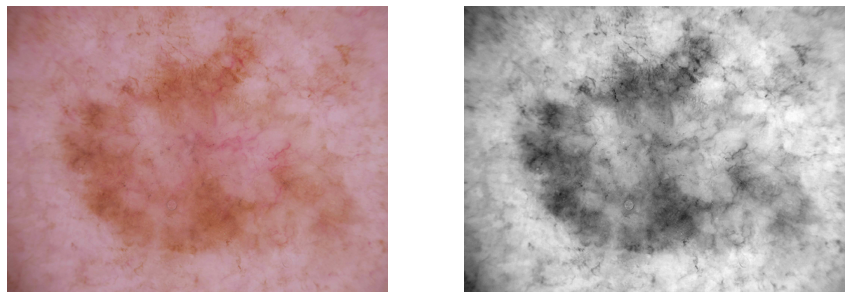

In [2]:
# it needs to convert the color code to display properly using matplotlib
# OpenCV uses BGR whereas matplotlib uses RGB
rgb_img = cv.cvtColor(cv.imread('./ham10k_images/ISIC_0029318.jpg'), cv.COLOR_BGR2RGB)
bw_img = cv.cvtColor(rgb_img, cv.COLOR_BGR2GRAY)

if rgb_img is None:
    print('Could not read RGB the image.')

if bw_img is None:
    print('Could not read B&W the image.')

fig, axes = plt.subplots(1, 2, figsize=(15,15))

for img, axe in zip([rgb_img, bw_img], [0, 1]):
    axes[axe].axis('off')
    axes[axe].imshow(img, cmap='gray')

In [3]:
test = cv.resize(rgb_img, (256, 256))

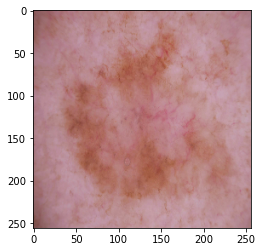

In [4]:
plt.imshow(test)

## B&W 

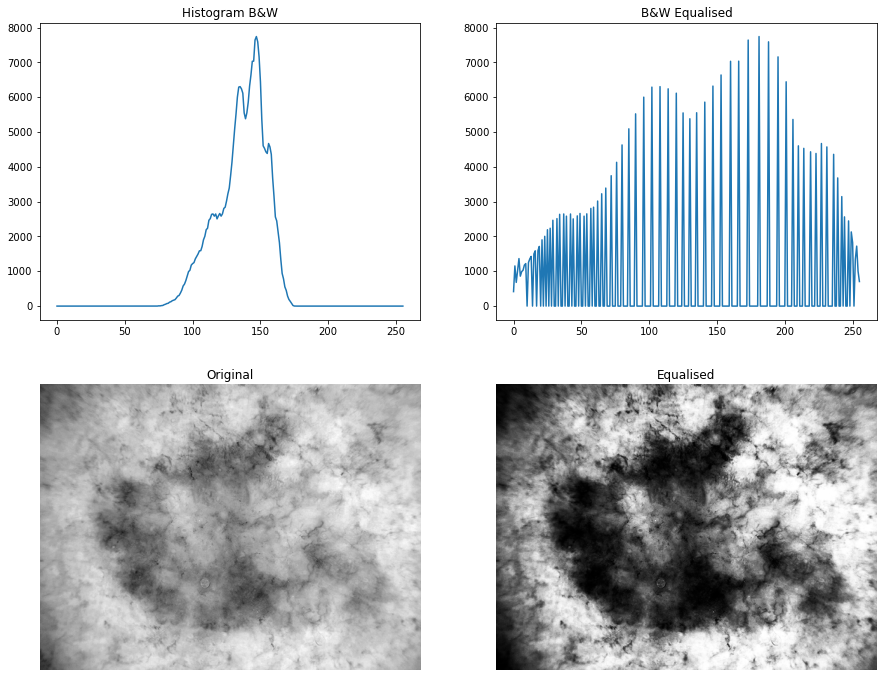

In [5]:
hp.compare_hist(bw_img)

## RGB

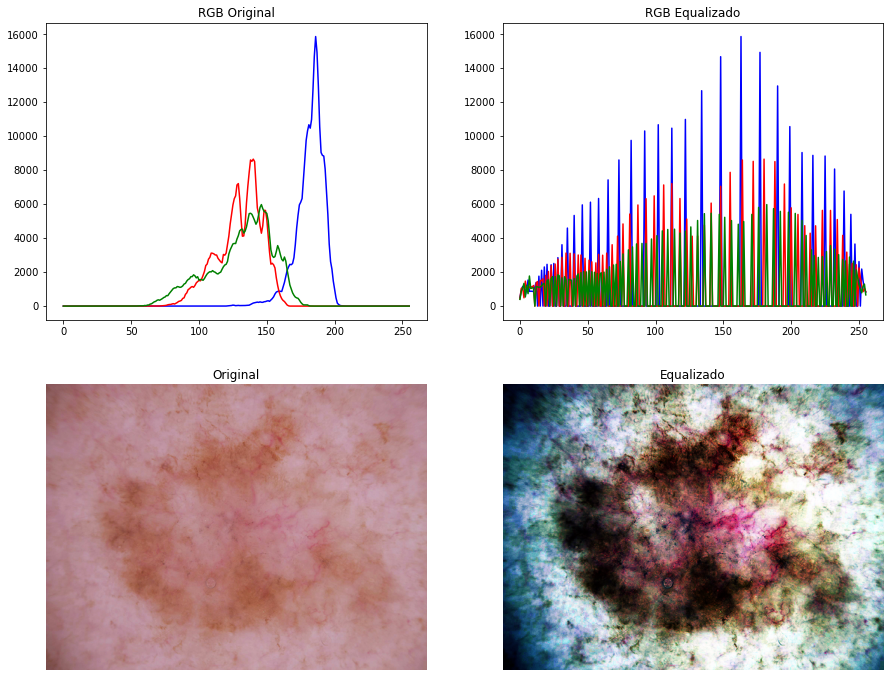

In [3]:
hp.compare_hist(rgb_img, bw=False)

## Metadata

In [7]:
path_meta = './metadata/HAM10000_metadata.csv'
ham10k_df = hp.create_metadata_df(path_meta)

In [8]:
ham10k_df.head(3)

,lesion_id,dx,dx_type,age,sex,localization,lesion_type
image_id,,,,,,,
ISIC_0024306,HAM_0000550,nv,follow_up,45.0,male,trunk,melanocytic nevi
ISIC_0024307,HAM_0003577,nv,follow_up,50.0,male,lower extremity,melanocytic nevi
ISIC_0024308,HAM_0001477,nv,follow_up,55.0,female,trunk,melanocytic nevi


In [9]:
ham10k_df.isna().sum()

lesion_id        0
dx               0
dx_type          0
age             57
sex              0
localization     0
lesion_type      0
dtype: int64

In [10]:
ham10k_df_pt = hp.translate_dataset(ham10k_df)

In [11]:
ham10k_df_pt.head()

,lesion_id,dx,dx_type,age,sex,localization,lesion_type
image_id,,,,,,,
ISIC_0024306,HAM_0000550,nv,follow_up,45.0,homem,tronco,nevo melanocítico
ISIC_0024307,HAM_0003577,nv,follow_up,50.0,homem,extr. inferior,nevo melanocítico
ISIC_0024308,HAM_0001477,nv,follow_up,55.0,mulher,tronco,nevo melanocítico
ISIC_0024309,HAM_0000484,nv,follow_up,40.0,homem,tronco,nevo melanocítico
ISIC_0024310,HAM_0003350,mel,histo,60.0,homem,peito,melanoma


### Exploratory Data Analysis

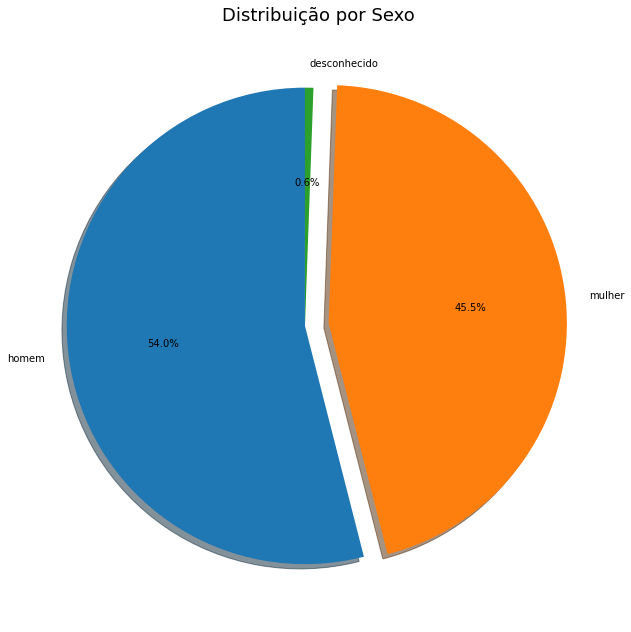

In [12]:
fig1, ax1 = plt.subplots(figsize=(10,11))
ax1.pie(ham10k_df_pt.sex.value_counts().values, 
        explode=(0, 0.1, 0), 
        labels=ham10k_df_pt.sex.value_counts().index, 
        autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.rc('font', size=15)
plt.rc('axes', labelsize=20)
plt.title('Distribuição por Sexo');

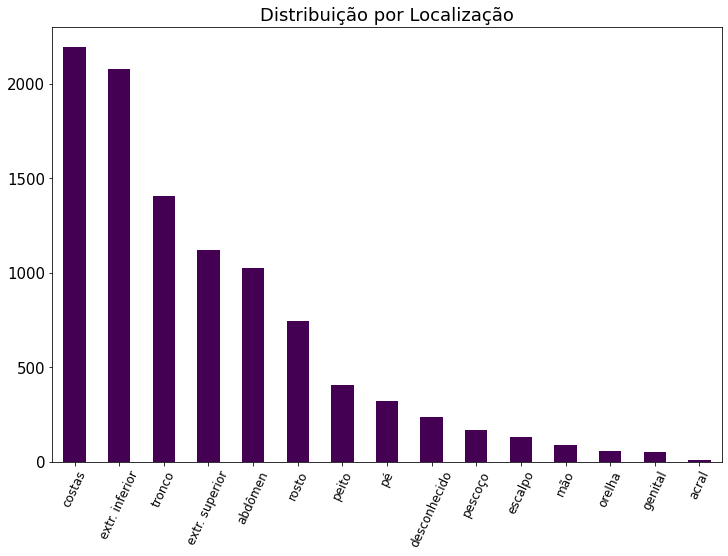

In [13]:
ham10k_df_pt.localization.value_counts().plot(kind='bar', 
                                              figsize=(12,8), 
                                              cmap='viridis', 
                                              title='Distribuição por Localização')

plt.xticks(rotation = 65, fontsize=12);

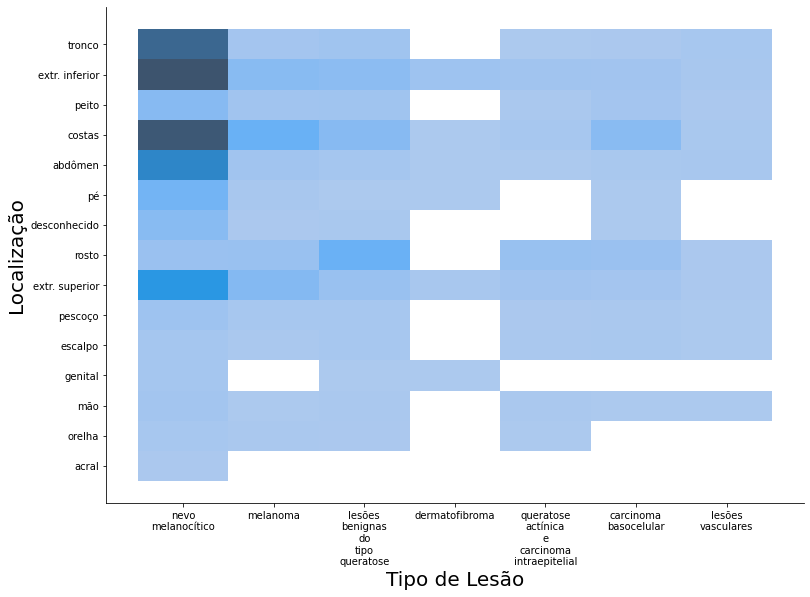

In [16]:
import textwrap as tw


ax = sns.displot(ham10k_df_pt, x="lesion_type", y="localization", height=8, aspect=1.5)

xticks = [y for x in list(plt.xticks())[1:] for y in x]

texts = ['\n'.join(t.get_text().split(' '))  for t in xticks]
#print(texts)

plt.xlabel('Tipo de Lesão')
plt.ylabel('Localização')
ax.set_xticklabels(texts)
plt.xticks(fontsize=10, rotation=0);
plt.yticks(fontsize=10, rotation=0);

In [ ]:
import fnmatch

In [17]:
dirname = os.path.relpath('./ham10k_images/')
print(dirname)

ham10k_images


In [19]:
filenames = os.listdir(dirname)

In [ ]:
list(map(lambda x: os.path.splitext(x)[0], sorted(filenames))) == ham10k_df.index.tolist()

In [ ]:
for dirname, _, filenames in os.walk(dirname):
    for filename in filenames:
        # get the img id by removing file extension
        img_id, _ = os.path.splitext(filename)
        if img_id in ham10k_df.index:
            print(img_id)
            break

In [21]:
img_dict = {}

for filename in filenames:
    # remove extension
    image_id, _ = os.path.splitext(filename)
    print(image_id)
    img = cv.cvtColor(cv.imread(dirname + '/' + filename), cv.COLOR_BGR2RGB)
    #plt.imshow(img)
    # ham10k_df.loc[image_id, 'pixel_repr'] = np.asarray(img)
    break

ISIC_0030858


In [22]:
img = cv.cvtColor(cv.imread(dirname + '/' + filename), cv.COLOR_BGR2RGB)

In [24]:
bw_eq = cv.equalizeHist(bw_img)

ret, thresh = cv.threshold(bw_eq,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

In [25]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

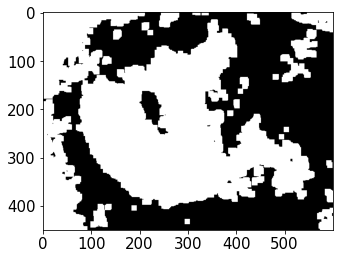

In [26]:
plt.imshow(sure_bg, cmap='gray')

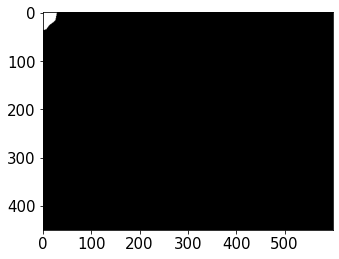

In [27]:
plt.imshow(sure_fg, cmap='gray')

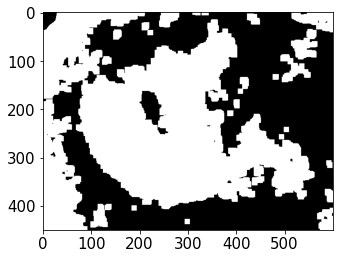

In [28]:
plt.imshow(unknown, cmap='gray')

In [29]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

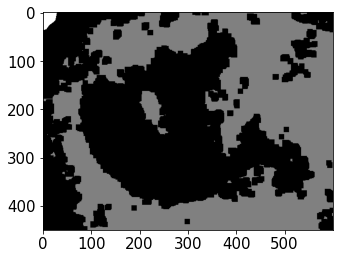

In [30]:
plt.imshow(markers, cmap='gray')

In [31]:
ret,thresh = cv.threshold(bw_eq,127,255,0)
contours,hierarchy = cv.findContours(thresh, 1, 2)
cnt = contours[0]
M = cv.moments(cnt)
print( M )

{'m00': 2.0, 'm10': 1128.0, 'm01': 894.0, 'm20': 636192.3333333333, 'm11': 504216.0, 'm02': 399618.3333333333, 'm30': 358812852.0, 'm21': 284377973.0, 'm12': 225384740.0, 'm03': 178629693.0, 'mu20': 0.3333333332557231, 'mu11': 0.0, 'mu02': 0.3333333333139308, 'mu30': 1.1920928955078125e-07, 'mu21': 3.4691765904426575e-08, 'mu12': 1.0943040251731873e-08, 'mu03': 2.9802322387695312e-08, 'nu20': 0.08333333331393078, 'nu11': 0.0, 'nu02': 0.0833333333284827, 'nu30': 2.1073424255447017e-08, 'nu21': 6.132695730589074e-09, 'nu12': 1.934474492199238e-09, 'nu03': 5.268356063861754e-09}


In [32]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

area = cv.contourArea(cnt)
perimeter = cv.arcLength(cnt,True)

epsilon = 0.1*cv.arcLength(cnt,True)
approx = cv.approxPolyDP(cnt,epsilon,True)

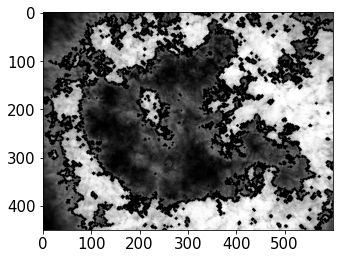

In [33]:
for contour in contours:
   cv.drawContours(bw_eq, contour, -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(bw_eq, cmap='gray')

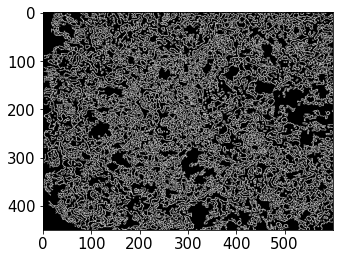

In [34]:
edged = cv.Canny(bw_eq, 0, 150)
plt.imshow(edged, cmap='gray')